In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score, accuracy_score, precision_score, recall_score, confusion_matrix, 
    classification_report, silhouette_score, silhouette_samples
)
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.cm as cm

In [35]:
df = pd.read_csv('../data/processed/combined-swell-classification-hrv-train-dataset.csv')

In [36]:
val = pd.read_csv('../data/processed/combined-swell-classification-hrv-validation-dataset.csv')

In [37]:
test = pd.read_csv('../data/processed/combined-swell-classification-hrv-test-dataset.csv')

In [38]:
df = pd.concat([df, val]) # 352474 entries to train and validated combined

In [39]:
## NOTES ON FEATURES
# RR is the peak in a heartbeat
# RR interval (RRI) is the distance between peaks in milliseconds between beats from an ECG
# RMSDD is the square root of the mean distance between RR for a period of time
# RMSDD is used as HRV calculation based on one minute intervals
# SDNN is the standard deviaiton of all the RR intervals

## NOTES ON EXPERIMENT CONDITIONS
# Conditions are R: rest, N: no stress, T: time pressure, I: interruption 
# No stress - Allowed to work for a maximum 45 minutes but they don't know the duration 
# Interruption - Received 8 emails in the middle of the assigned task 
# Time Pressure - Time limit of 2/3 to complete task based on duration in no stress

## NOTES ON STRESS QUSTIONNAIRE TAKEN AFTER EVERY EXPERIMENT CONDITION

# NASA TLX - NASA Task Load Index is used as a measure of mental load: High, Medium, Low
# multi-dimensional rating for mental demand, physical demand, temporal deman, effort,
# performance, and frustration

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352474 entries, 0 to 39163
Data columns (total 69 columns):
MEAN_RR                     352474 non-null float64
MEDIAN_RR                   352474 non-null float64
SDRR                        352474 non-null float64
RMSSD                       352474 non-null float64
SDSD                        352474 non-null float64
SDRR_RMSSD                  352474 non-null float64
HR                          352474 non-null float64
pNN25                       352474 non-null float64
pNN50                       352474 non-null float64
SD1                         352474 non-null float64
SD2                         352474 non-null float64
KURT                        352474 non-null float64
SKEW                        352474 non-null float64
MEAN_REL_RR                 352474 non-null float64
MEDIAN_REL_RR               352474 non-null float64
SDRR_REL_RR                 352474 non-null float64
RMSSD_REL_RR                352474 non-null float64
SDSD_R

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352474 entries, 0 to 39163
Data columns (total 69 columns):
MEAN_RR                     352474 non-null float64
MEDIAN_RR                   352474 non-null float64
SDRR                        352474 non-null float64
RMSSD                       352474 non-null float64
SDSD                        352474 non-null float64
SDRR_RMSSD                  352474 non-null float64
HR                          352474 non-null float64
pNN25                       352474 non-null float64
pNN50                       352474 non-null float64
SD1                         352474 non-null float64
SD2                         352474 non-null float64
KURT                        352474 non-null float64
SKEW                        352474 non-null float64
MEAN_REL_RR                 352474 non-null float64
MEDIAN_REL_RR               352474 non-null float64
SDRR_REL_RR                 352474 non-null float64
RMSSD_REL_RR                352474 non-null float64
SDSD_R

In [43]:
df.columns

Index(['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50', 'SD1', 'SD2', 'KURT', 'SKEW', 'MEAN_REL_RR',
       'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR',
       'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'VLF', 'VLF_PCT',
       'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF',
       'HF_LF', 'sampen', 'higuci', 'condition', 'subject_id', 'MEAN_RR_LOG',
       'MEAN_RR_SQRT', 'TP_SQRT', 'MEDIAN_REL_RR_LOG', 'RMSSD_REL_RR_LOG',
       'SDSD_REL_RR_LOG', 'VLF_LOG', 'LF_LOG', 'HF_LOG', 'TP_LOG', 'LF_HF_LOG',
       'RMSSD_LOG', 'SDRR_RMSSD_LOG', 'pNN25_LOG', 'pNN50_LOG', 'SD1_LOG',
       'KURT_YEO_JONSON', 'SKEW_YEO_JONSON', 'MEAN_REL_RR_YEO_JONSON',
       'SKEW_REL_RR_YEO_JONSON', 'LF_BOXCOX', 'HF_BOXCOX', 'SD1_BOXCOX',
       'KURT_SQUARE', 'HR_SQRT', 'MEAN_RR_MEAN_MEAN_REL_RR', 'SD2_LF', 'HR_LF',
       'HR_HF', 'HF_VLF', 'NasaTLX class', 'Condition Label', 'NasaTLX Label'],
      dtype='object')

In [44]:
sorted(df['subject_id'].unique()), len(df['subject_id'].unique())

([1,
  2,
  3,
  4,
  5,
  6,
  7,
  9,
  10,
  12,
  13,
  14,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 22)

In [45]:
# Participants 8, 11, 15 were been removed

In [46]:
df['condition'].unique()

array(['interruption', 'time pressure', 'no stress'], dtype=object)

In [47]:
df['NasaTLX class'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [48]:
df['NasaTLX Label'].unique()

array([2, 1, 0])

In [49]:
subjects = df['subject_id'].unique()
lengths = []
for subject in subjects:
    lengths.append(len(df[df['subject_id'] == subject]))
    print(f"{subject}: {len(df[df['subject_id'] == subject])}")
np.mean(lengths)
# Average of about 16,000 datapoints per subject

4: 17552
17: 16938
18: 16764
22: 13667
10: 17662
12: 17677
14: 17702
7: 15841
21: 14925
20: 13310
24: 14571
23: 12125
13: 14558
16: 19347
6: 18776
19: 17931
9: 14320
2: 17474
1: 17312
5: 16234
3: 14411
25: 13377


16021.545454545454

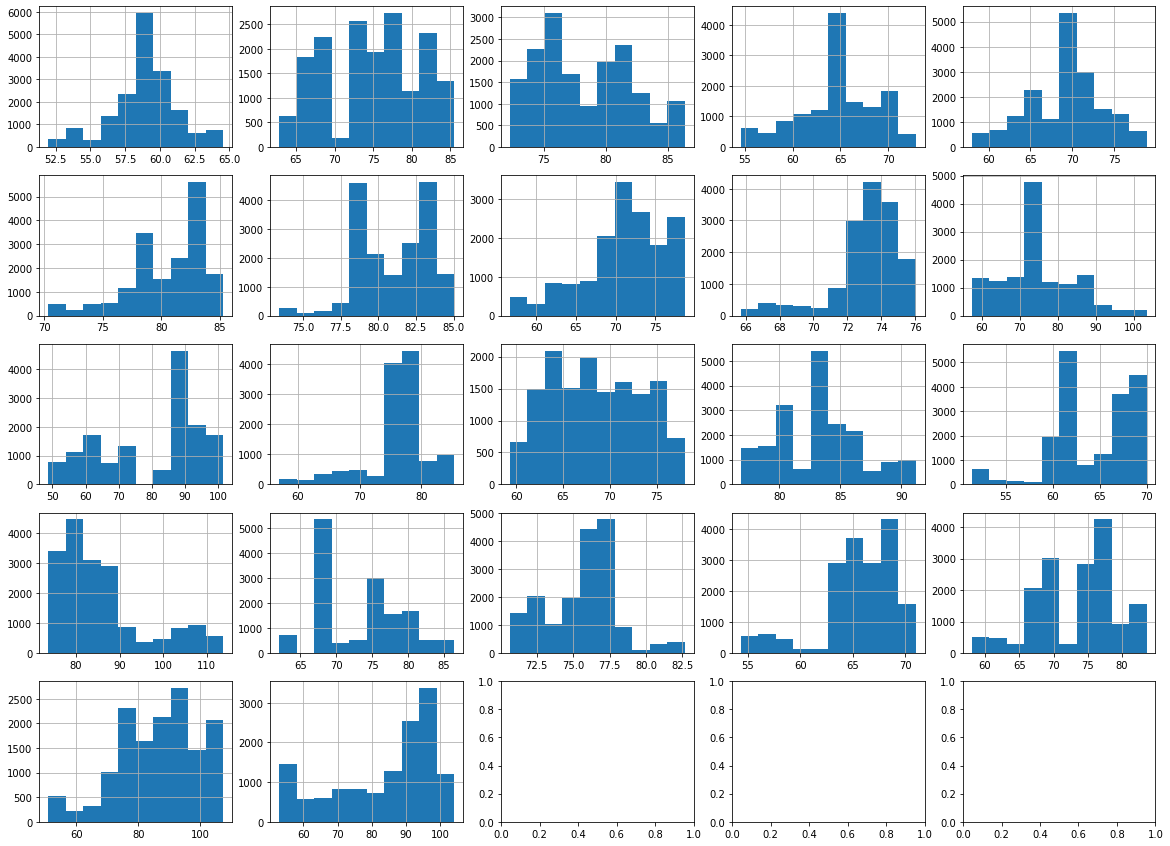

In [50]:
# Heart Rate Histogram

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for ax, subject in zip(axs.flatten(), subjects):
    df[df['subject_id'] == subject]['HR'].hist(ax=ax)

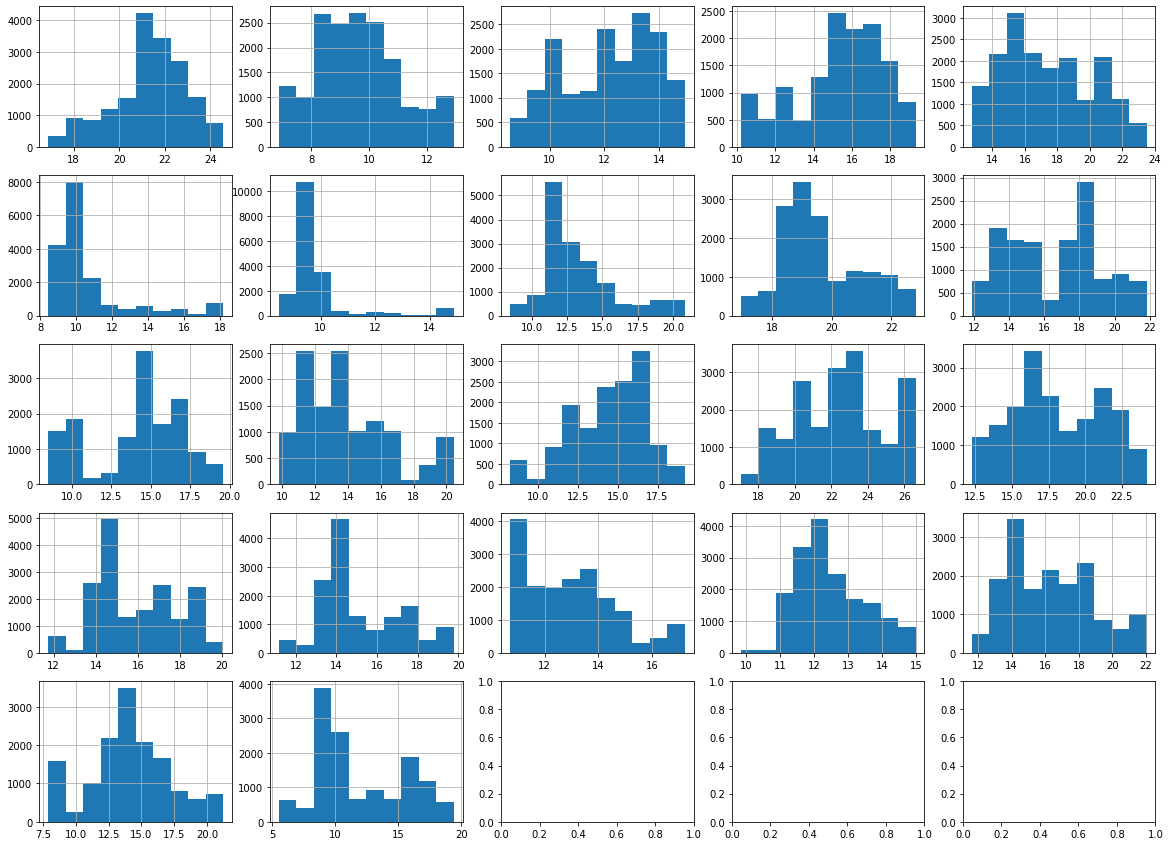

In [51]:
# RMSDD histogram

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for ax, subject in zip(axs.flatten(), subjects):
    df[df['subject_id'] == subject]['RMSSD'].hist(ax=ax)

In [52]:
df[df['subject_id'] == 1][['condition', 'NasaTLX class']][40:50]

,condition,NasaTLX class
814,time pressure,medium
824,interruption,medium
830,no stress,medium
866,no stress,medium
874,time pressure,medium
880,time pressure,medium
894,no stress,medium
902,time pressure,medium
906,no stress,medium
915,no stress,medium


In [53]:
df.head()

,MEAN_RR,MEDIAN_RR,SDRR,RMSSD,SDSD,SDRR_RMSSD,HR,pNN25,pNN50,SD1,...,KURT_SQUARE,HR_SQRT,MEAN_RR_MEAN_MEAN_REL_RR,SD2_LF,HR_LF,HR_HF,HF_VLF,NasaTLX class,Condition Label,NasaTLX Label
0,1174.144734,1220.305100,146.274795,20.453938,20.453875,7.151424,52.018538,21.266667,1.933333,14.467900,...,0.099908,7.212388,2.199784e+07,0.153091,0.038591,43.650130,0.000447,high,1,2
1,895.342387,893.943175,56.174431,9.294380,9.294329,6.043914,67.278216,0.933333,0.000000,6.574276,...,0.203463,8.202330,2.879915e+07,0.241013,0.204811,6.144360,0.015995,high,1,2
2,764.218684,767.859965,77.160764,11.788299,11.787062,6.545539,79.342692,3.066667,0.000000,8.337493,...,0.138674,8.907452,-3.266219e+06,0.155760,0.113586,3.932715,0.013721,medium,1,1
3,854.776805,830.149445,84.950716,10.797540,10.796497,7.867599,70.867408,2.733333,0.200000,7.636824,...,0.698643,8.418278,-5.553280e+06,0.223233,0.131948,4.348861,0.033438,low,2,0
4,1093.290552,1121.317600,145.395568,17.550094,17.550090,8.284603,55.994337,16.066667,0.933333,12.413929,...,0.058267,7.482936,-6.849979e+07,0.215492,0.058790,33.929483,0.000479,medium,2,1


In [54]:
columns_to_drop = ['subject_id', 'HR', 'condition', 'Condition Label', 'NasaTLX class', 'NasaTLX Label']
main_columns_to_keep = ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'HR',
       'pNN25', 'pNN50']
# Mean RR: Mean of all RR intervals
# Median RR: Median of all RR intervals
# SDRR: Standard Deviation of all intervals
# RMSDD: Square root of the mean of the sum of the squares of the difference between adjacent RR intervals
# SDSD: Standard deviation of all interval of differences between adjacent RR intervals 
# SDRR_RMSDD: Ratio of SDRR over RMSSD
# HR: Heart Rate
# pNN25: % of adjacent RR intervals differing by more than 25 ms
# pNN50: % of adjacent RR intervals differing by more than 50 ms

In [55]:
rf = RandomForestClassifier()
rf_grid = {'n_estimators': [100, 250, 500], 'max_depth': [2, 3]}

In [56]:
# Using just HR to predict stress 
X = df['HR'].values.reshape(-1, 1)
y = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf1 = GridSearchCV(rf, rf_grid)
clf1.fit(X_train, y_train)
# Accuracy Score for just using HR
accuracy_score(y_test, clf1.predict(X_test))

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.4909156935507666

In [57]:
# Using just HRV to predict stress
X4 = df[['RMSSD']]
y4 = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X4, y4)
clf2 = GridSearchCV(rf, rf_grid)
clf2.fit(X_train, y_train)
# Accuracy Score for just using HRV
accuracy_score(y_test, clf2.predict(X_test))

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.4206924726789909

In [58]:
# Using HR and HRV to predict stress
X3 = df[['HR', 'RMSSD']]
# X3 = StandardScaler().fit_transform(X3)
y3 = df['NasaTLX Label'].values
X_train, X_test, y_train, y_test = train_test_split(X3, y3)
clf3 = GridSearchCV(rf, rf_grid)
clf3.fit(X_train, y_train)
# Accuracy Score for using HR + HV
accuracy_score(y_test, clf3.predict(X_test))

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.4978381506825997

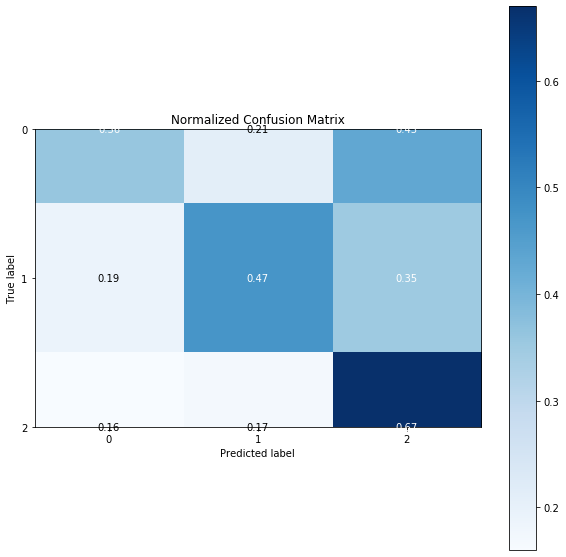

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_confusion_matrix(y_test, clf3.predict(X_test), normalize=True, ax=ax)

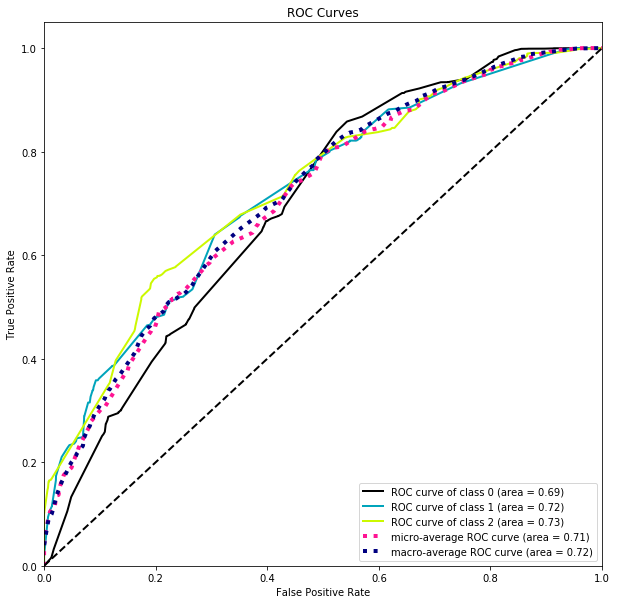

In [60]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_roc(y_test, clf3.predict_proba(X_test), ax=ax)

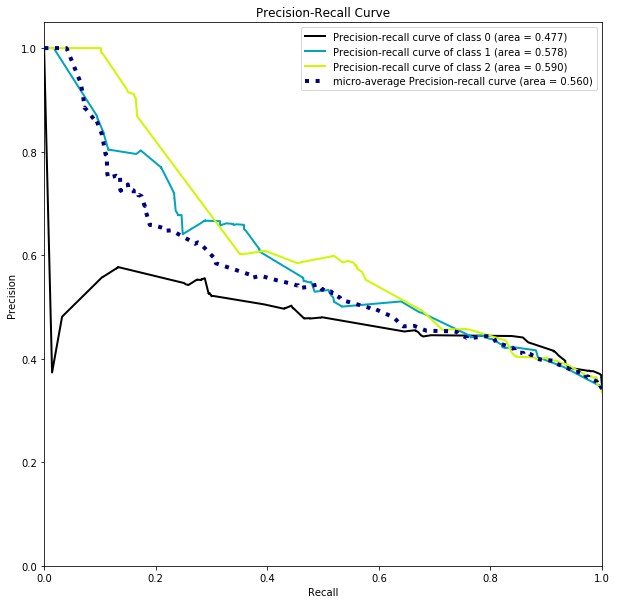

In [61]:
fig, ax = plt.subplots(figsize=(10, 10))
skplt.metrics.plot_precision_recall(y_test, clf3.predict_proba(X_test), ax=ax)

In [62]:
df['RMSSD_LOG'] = np.log(df['RMSSD'])
df['RMSSD_SQUARED'] = df['RMSSD']**2

In [ ]:
POSSIBLE_COLUMNS = ['HF',
                    'HF_BOXCOX',
                    'HF_LF',
                    'HF_LOG',
                    'HF_NU',
                    'HF_PCT',
                    'HF_VLF',
                    'HR',
                    'HR_HF',
                    'HR_LF',
                    'HR_SQRT',
                    'KURT',
                    'KURT_REL_RR',
                    'KURT_SQUARE',
                    'KURT_YEO_JONSON',
                    'LF',
                    'LF_BOXCOX',
                    'LF_HF',
                    'LF_HF_LOG',
                    'LF_LOG',
                    'LF_NU',
                    'LF_PCT',
                    'MEAN_REL_RR',
                    'MEAN_REL_RR_YEO_JONSON',
                    'MEAN_RR',
                    'MEAN_RR_LOG',
                    'MEAN_RR_MEAN_MEAN_REL_RR',
                    'MEAN_RR_SQRT',
                    'MEDIAN_REL_RR',
                    'MEDIAN_REL_RR_LOG',
                    'MEDIAN_RR',
                    'RMSSD',
                    'RMSSD_LOG',
                    'RMSSD_SQUARED',
                    'RMSSD_REL_RR',
                    'RMSSD_REL_RR_LOG',
                    'SD1',
                    'SD1_BOXCOX',
                    'SD1_LOG',
                    'SD2',
                    'SD2_LF',
                    'SDRR',
                    'SDRR_REL_RR',
                    'SDRR_RMSSD',
                    'SDRR_RMSSD_LOG',
                    'SDRR_RMSSD_REL_RR',
                    'SDSD',
                    'SDSD_REL_RR',
                    'SDSD_REL_RR_LOG',
                    'SKEW',
                    'SKEW_REL_RR',
                    'SKEW_REL_RR_YEO_JONSON',
                    'SKEW_YEO_JONSON',
                    'TP',
                    'TP_LOG',
                    'TP_SQRT',
                    'VLF',
                    'VLF_LOG',
                    'VLF_PCT',
                    'higuci',
                    'pNN25',
                    'pNN25_LOG',
                    'pNN50',
                    'pNN50_LOG',
                    'sampen']

COLUMNS_TO_KEEP = ['HF',
                   'HF_BOXCOX',
                   'HF_LF',
                   'HF_NU',
                   'HF_PCT',
                   'HR',
                   'HR_HF',
                   'HR_LF',
                   'HR_SQRT',
                   'LF',
                   'LF_BOXCOX',
                   'LF_HF',
                   'LF_NU',
                   'LF_PCT',
                   'MEAN_RR',
                   'MEDIAN_RR',
                   'RMSSD',
                   'RMSSD_LOG',
                   'RMSSD_SQUARED',
                   'RMSSD_REL_RR',
                   'SD1_BOXCOX',
                   'SDRR',
                   'SDRR_RMSSD',
                   'SDRR_RMSSD_REL_RR',
                   'SDSD',
                   'TP',
                   'VLF',
                   'VLF_PCT',
                   'pNN25',
                   'pNN50']

RF_GRID = {'n_estimators': [100, 250, 500, 1000], 'max_depth': [2, 3]}

def random_included_and_excluded_df(df, total_excluded=5):
    random_subject_ids = np.random.choice(df['subject_id'].unique(), total_excluded)
    excluded_df = df[df['subject_id'].isin(random_subject_ids)]
    included_df = df[~df['subject_id'].isin(random_subject_ids)]
    return included_df, excluded_df

def rf_for_subject_subset(included_df):
   X = included_df
   X = X[POSSIBLE_COLUMNS]
   X = StandardScaler().fit_transform(X)
   y = included_df['NasaTLX Label'].values
   X_train, X_test, y_train, y_test = train_test_split(X, y)
   clf = GridSearchCV(RandomForestClassifier(), RF_GRID)
   clf.fit(X_train, y_train)
   print(f'Accuracy Score for Included Subset: {accuracy_score(y_test, clf.predict(X_test))}')
   return clf

def test_rf_on_excluded_subset(clf, excluded_df):
    X_test = excluded_df[POSSIBLE_COLUMNS]
    X_test = StandardScaler().fit_transform(X_test)
    y_test = excluded_df['NasaTLX Label'].values
    print(f'Accuracy Score for Excluded Subset without Calibration: {accuracy_score(y_test, clf.predict(X_test))}')

def combined_included_excluded_without_calibration(included_df, excluded_df):
    clf = rf_for_subject_subset(included_df)
    test_rf_on_excluded_subset(excluded_df)

# Default sample set to around 6.25% of data
def calibrated_rf_with_sample_of_excluded_subset(included_df, excluded_df, samples_per_subject=1000):
    for i in excluded_df['subject_id'].unique():
        random_sample = df[df['subject_id'] == i].sample(n=samples_per_subject)
        included_df = pd.concat([included_df, random_sample])
        # remove random sample from excluded subset
        excluded_df.drop(random_sample.index, inplace=True)

    calibrated_rf = rf_for_subject_subset(included_df)
    X_test = excluded_df[POSSIBLE_COLUMNS]
    X_test = StandardScaler().fit_transform(X_test)
    y_test = excluded_df['NasaTLX Label'].values
    print(
        f'Accuracy Score for Excluded Subset with Calibrated RF: {accuracy_score(y_test, calibrated_rf.predict(X_test))}')
    return calibrated_rf

def test_on_validation_df(validation_df):
    X_test = validation_df[POSSIBLE_COLUMNS]
    X_test = StandardScaler().fit_transform(X_test)
    y_test = validation_df['NasaTLX Label'].values
    print(f'Accuracy Score for Validation Subset without Calibration: {accuracy_score(y_test, clf.predict(X_test))}')

def rf_predictions_for_each_subject(df):
    predictions = []
    for i in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == i]
        X = subject_df
        X = X[POSSIBLE_COLUMNS]
        X = StandardScaler().fit_transform(X)
        y = subject_df['NasaTLX Label'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = GridSearchCV(RandomForestClassifier(), RF_GRID)
        clf.fit(X_train, y_train)
        predictions.append(clf.predict(X_test))
        print(f'Accuracy Score for Included Subject {i}: {accuracy_score(y_test, clf.predict(X_test))}')
    return predictions

In [88]:
random_subject_ids = np.random.choice(df['subject_id'].unique(), 5)
validation_df = df[df['subject_id'].isin(random_subject_ids)]
df = df[~df['subject_id'].isin(random_subject_ids)]

In [92]:
included_df, excluded_df = random_included_and_excluded_df(df, total_excluded=5)

In [ ]:
non_calibrated_rf = combined_included_excluded_without_calibration(included_df, excluded_df)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
sorted(list(zip(POSSIBLE_COLUMNS, non_calibrated_rf.best_estimator_.feature_importances_)), key=lambda x: x[1])

In [72]:
non_calibrated_rf.best_params_

{'max_depth': 3, 'n_estimators': 100}

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))

feat_scores = pd.DataFrame({'Fraction of Samples Affected' : calibrated_rf.best_estimator_.feature_importances_},
                           index=POSSIBLE_COLUMNS)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
plt.tight_layout()
feat_scores.plot(kind='barh', ax=ax)

In [ ]:
calibrated_rf = calibrated_rf_with_sample_of_excluded_subset(included_df, excluded_df)

In [76]:
def rf_predictions_for_each_subject(df):
    predictions = []
    for i in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == i]
        X = subject_df
        X = X[COLUMNS_TO_KEEP]
        X = StandardScaler().fit_transform(X)
        y = subject_df['NasaTLX Label'].values
        X_train, X_test, y_train, y_test = train_test_split(X, y)
        clf = GridSearchCV(RandomForestClassifier(), RF_GRID)
        clf.fit(X_train, y_train)
        predictions.append(clf.predict(X_test))
        print(f'Accuracy Score for Included Subject {i}: {accuracy_score(y_test, clf.predict(X_test))}')
    return predictions

In [77]:
predictions = rf_predictions_for_each_subject(df)

/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 4: 0.9425706472196901


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 17: 0.9723730814639906


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 18: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 22: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 10: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 12: 0.998868778280543


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 14: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 7: 0.9646553900530169


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 21: 0.9983922829581994


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 20: 0.9750600961538461


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 24: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 23: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 13: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 16: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 6: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 19: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 9: 0.9988826815642458


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 2: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 1: 1.0


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 5: 0.9990145355999015


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 3: 0.9233971690258118


/Users/sachin/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Accuracy Score for Included Subject 25: 1.0


In [ ]:
X = df[['HR', 'RMSSD']]
range_n_clusters = range(2, 23)

# taken from sklearn
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
            "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap('Spectral')
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed

    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                    "with n_clusters = %d" % n_clusters),
                    fontsize=14, fontweight='bold')

    plt.show()